# Introduction

In this assignment we will try and replicate some of the findings in Blitz and van Vliet's paper "The Volatility Effect" (2007). Namely, that "stocks with low historical volatility have superior risk-adjusted returns, both in terms of Sharpe ratios and in terms of CAPM alphas." That means that we expect that a portfolio of low risk stocks (lower volatility) entails higher risk adjusted returns than the broader market. This can be used as an investment strategy that overperforms the market.

In order to do that, portfolios containing stocks of 48 industries will be divided in deciles based 3-year weekly volatility, i.e., the average of its volatility for the past three years. The large window for volatility ensures a lower decile turnover.

At the end of each month, deciles are rebalanced based on the historical volatility. Excess return, its standard deviation, Sharpe Ratio and CAPM's Beta and Alpha are calculated for each decile on a monthly basis. T statistics for the Sharpe Ratio and alpha are also calculated. Risk measures will also be calculated for each decile, namely, return during up and down markets and maximum drawdown. The market return used is the aggregate return of the 48 industry portfolios. Information about the industry portfolios is provided on the Appendix.

We expect our results to be similar to the ones in Blitz and van Vliet (Table 1). Although they use data from the US, Europe and Japan, their results hold for each region. Therefore our sample, which uses US data and similar time span should produce similar results. For this reason we expect the lower deciles (which contain stocks with the lowest historical volatility) to have higher risk adjusted returns. Beta should increase with increasing deciles and Alpha should decrease. Return during up (down) markets should increase (decrease) with deciles and maximum drawdown should be lower on lower deciles.

The packages used to produce our results:

In [1]:
import pandas as pd
import numpy as np
from IPython import display
from statsmodels.formula.api import ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Table 1:

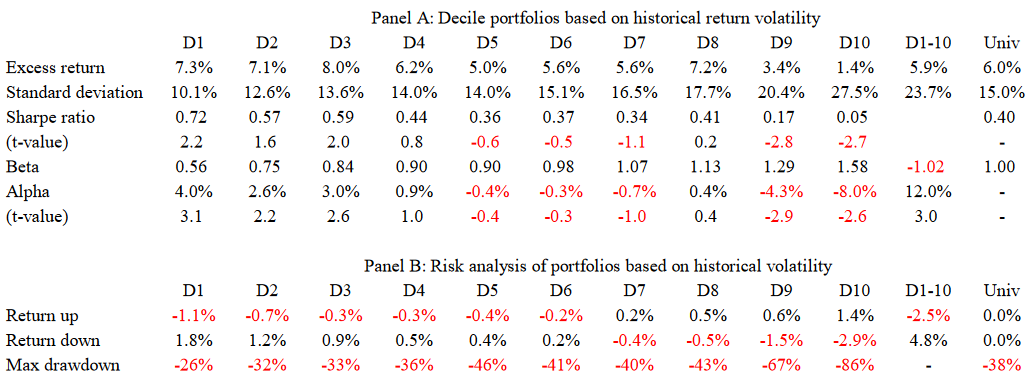

In [2]:
display.Image('https://raw.githubusercontent.com/CaioVezzaSoares/The-Volatility-Effect/main/Table.PNG')

The remainder of this document consists of five sections. Section 2 presents the dataset used and the steps taken to get it ready to use. Section 3 defines the variables of interests and details how they were calculated from the dataset. Sections 4 and 5 present the results and comment on them. Section 6 briefly concludes.

# Dataset

The dataset used was obtained from Kenneth French's [data library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). It consists of daily returns for 48 industry porfolios, from 1926 to 2020. Stocks on the portfolios are listed on NYSE, AMEX and NASDAQ. The dataset containing data for risk free rates was also obtained from this library. They are "48 Industry Portfolios [Daily]" and "Fama/French 3 Factors [Daily]", respectively.

In order to be as close to Blitz and van Vliet analysis as possible, the equally weighted portfolios will be used. For the same reason, the scope of the analysis will be from 1986 to 2020.

In [3]:
# Importing the datasets

## Industry Portfolios

### port contains the daily returns for the 48 industry portfolios

port = pd.read_csv('https://github.com/CaioVezzaSoares/The-Volatility-Effect/raw/main/48_Industry_Portfolios_daily.CSV', header = 24861)

### The "header = 24861" argument select the returns for the equally weighted portfolios, which start after the value weighted ones

## Risk Free Rate

## ff contains the risk free rate (RF). Market excess return (Mkt-RF) and the factors SMB and HML will not be used

ff = pd.read_csv('https://github.com/CaioVezzaSoares/The-Volatility-Effect/raw/main/F-F_Research_Data_Factors_daily.CSV', header = 3)

ff.drop(columns=['Mkt-RF','SMB','HML'], inplace = True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Data Cleanup

## Some columns will be renamed for ease in understanding

port.rename(columns={'Unnamed: 0': 'Date'}, inplace = True)
ff.rename(columns={'Unnamed: 0': 'Date'}, inplace = True)

## Drop 'Copyright 2020 Kenneth R. French' in last row

port.drop([24854], inplace = True)
ff.drop([24854], inplace = True)

## Missing data are indicated by -99.99 or -999 in port

port.replace(-99.99, np.NaN, inplace = True)
port.replace(-999, np.NaN, inplace = True)


In [5]:
# Selecting observations for the desired period (1986 to 2020)

port['Date'] = pd.to_datetime(port['Date'],format='%Y%m%d')
ff['Date'] = pd.to_datetime(ff['Date'],format='%Y%m%d')

port = port.loc[port['Date'] > '31-12-1985']
ff = ff.loc[ff['Date'] > '31-12-1985']

port.reset_index(inplace=True,drop=True)
ff.reset_index(inplace=True,drop=True)


In [6]:
# Check for missing values

if port.isna().any().any():
    print("There are missing values in port.")
else:
    print("There are no missing values in port.")

if ff.isna().any().any():
    print("There are missing values in ff.")
else:
    print("There are no missing values in ff.")


There are no missing values in port.
There are no missing values in ff.


# Variables

For the analysis we will sort the industry portfolios into volatility deciles, and then calculate return statistics. Specifically, we will calculate Excess Return, Standard Deviation, Sharpe Ratio, CAPM Beta and Alpha and Drawdown statistics.

Before we obtain the desired variables, some data transformation is required. Namely, the industry returns need to be converted to excess returns, i.e., their difference with the risk free rate, and those returns must be log-transformed. The resulting series of returns for industry **i** is:

$$R_{it} = ln[1+(r_{it} - RF_t)]$$

Where:  
* $R_{it}$: excess return for industry **i** in period **t**;  
* $r_{it}$: return for industry **i** in period **t**;
* $RF_t$: risk free rate for period **t**.

The excess return for industries is in natural logarithm so as "to make them additive over time", as put by Blitz and van Vliet. 

In [7]:
# Return Dataframe

ret = pd.DataFrame(columns = port.columns)

# Loop to populate industries return in return dataframe

for n in port.columns[1:]:
    ret[n] = np.log(port[n]/100 + 1)

## as porfolio returns in percentages (1.2% is "1.2"), they need to be divided by 100

# Adding Univ column, which will contain the daily average return of the 48 industries

ret.insert(len(ret.columns), "Univ", np.nan)

for i in range(0,len(ret)):
    ret.loc[i,"Univ"] = np.mean(ret.loc[i])

# Filling the Date column in ret

ret.Date = port.Date


With that, we have everything needed to begin calculating the variables of interest.

## Volatility

### Calculating Volatility Variables

Volatility will be calculated from the past three year weekly return, just as Blitz and van Vliet did on their paper.

In [8]:
# First, we'll calculate weekly volatility for the 48 industries

## Similarly to returns, we will create a dataframe to store the volatilities

volw = pd.DataFrame(columns = port.columns)

## The pandas rolling standard deviation function will be used to calculate volatility

for n in port.columns[1:]:
    volw[n] = ret[n].rolling(window = 5).std() * np.sqrt(5) 

### argument window is set to 5 to calculate weekly volatility

# Now, we calculate the 3 year average

## Set up the dataframe

vol3 = pd.DataFrame(columns = port.columns)

## The pandas rolling average function will be used to calculate volatility's 3 year moving average

for n in port.columns[1:]:
    vol3[n] = volw[n].rolling(window = 756).mean()


### Sorting into Volatility Deciles

Now, we are going to sort the industry portfolios in deciles based on the 3-year weekly volatility. First we need to rank them based on volatility.

In [9]:
# Creating dataframe with daily volatility ranks

rank = pd.DataFrame(columns = port.columns)

for i in range(0, len(vol3)):
        rank.loc[i] = vol3.iloc[i].rank()


The volatility deciles will be the following based on rank value:

1. 1:4
2. 5:9
3. 10:14
4. 15:19
5. 20:24
6. 25:29
7. 30:34
8. 35:39
9. 40:44
10. 45:48

With 1 being the lowest 3-year weekly volatility decile and 10 the highest.

In [10]:
# Dataframe for decile returns

deciles = pd.DataFrame(columns = port.columns)

d = [range(1, 5), range(5, 10), range(10, 15), range(15, 20), range(20, 25), range(25, 30), range(30, 35), range(35, 40), range(40, 45), range(45, 49)]

o = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in range(0,len(rank)):
    for n in port.columns[1:]:
        for r in range(10):
            if any(rank.loc[i, n] == d[r]):
                deciles.loc[i,n] = o[r]

deciles.Date = port.Date

deciles.reset_index(inplace=True,drop=True)

In [11]:
# Getting decile value for the end of each month, which is when the portfolios will be rebalanced

deciles2 = deciles.resample('M',on='Date').max().reset_index(drop=True)


In [12]:
print('The sample used spans from ', deciles['Date'][deciles.index.min()],' to ',deciles['Date'][deciles.index.max()])

The sample used spans from  1989-01-03 00:00:00  to  2020-10-30 00:00:00


Since the decile portfolios are formed based on the 3-year weekly volatility on last day of each month and we lost one week for the weekly volatility calculation, the returns used for the analysis will go from February 1989 to October 2010. 

## Return

The deciles return data will be calculated as follows:

### Excess Return

The excess return will be calculated as follows:

$$ R_i = \frac{1}{T} * \sum_{t=1}^{T} ln[1+(r_{it} - RF_t)]$$

Where:

* $R_i$: Average excess return for Decile **i**;
* $r_{it}$: Return for decile **i** in month **t**;
* $RF_t$: Risk-free return in month **t**;
* $T$: Number of months in the sample.


### Sharpe Ratio

The Sharpe Ratio will be calculated as follows:

$$SR_i = \frac{R_i}{\sigma_i}$$

Where:

* $SR_i$: Sharpe Ratio of decile **i**;
* $R_i$: Average excess return for Decile **i**;
* $\sigma_i$: Standard Deviation of $R_i$.

The equation for the t-value of the difference between a given Sharpe Ratio and the sample Sharpe Ratio is:

$$z = - \frac{SR_1 - SR_2}{\sqrt{\frac{1}{T}[2(1-\rho_{1,2})+\frac{1}{2}(SR_1^2 + SR_2^2 - SR_1SR_2[1+\rho_{1,2}])]}}$$

Where:

* $T$: Number of months in the sample
* $\rho_{1,2}$: correlation between returns

## CAPM Factors

CAPM factors $\alpha$ and $\beta$ are derived from the following OLS regression:

$$r_i = \alpha + \beta * r_m$$

Where:

* $r_i$: Time series of industry's **i** returns;
* $r_m$: Time series of market returns.

## Relative Performance

### Returns During Up and Down Markets  

The return during up (down) markets for decile **i** will be calculated as the difference between the mean return of decile **i** and the mean market return, in the months where market returns are positive (negative).   

### Maximum Drawdown 

Maximum Drawdown for decile **i** is the maximum possible loss sustained if one invested in it, i.e., the worst entry and worst exit moments

In [22]:
# Calculating variables

## Creating dataframe with excess returns (Portfolio returns - Risk free rate)

xs_ret = pd.DataFrame(columns = port.columns)

for n in port.columns[1:]:
  xs_ret[n] = 1 + ret[n] - (ff.RF/100)
  xs_ret[n] = xs_ret[n].apply(np.log)

# Risk free is in percentages (1.2% is 1.2) so a division by 100 is warranted

xs_ret.insert(49, 'Univ', np.nan)

xs_ret['Univ'] = 1 + ret['Univ'] - (ff.RF/100)
xs_ret['Univ'] = xs_ret['Univ'].apply(np.log)

xs_ret.Date = port.Date

# Monthly excess return

xs_ret.iloc[:,1:] += 1
xs_retm = xs_ret.resample('M', on = 'Date').prod().reset_index(drop=True) - 1
xs_retm.insert(0,'Date',port['Date'])

## Populating decile daily returns dataframe 

dec_ret = pd.DataFrame(columns = ['Date', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '1-10', 'Univ'])

dec_ret['Date'] = deciles2['Date']
dec_ret['Univ'] = xs_retm['Univ']

x = []

for i in range(0,len(deciles2)):
    for d in range(1,11):
        for n in port.columns[1:]:
            if deciles2.loc[i, n] == d:
                x.append(xs_retm.loc[i, n])
                dec_ret.loc[i, d]= np.mean(x)
                x = []

dec_ret['1-10'] = dec_ret[1]-dec_ret[10]

In [17]:
# Populating Panel A dataframe

data = pd.DataFrame()
panel_A = pd.DataFrame(index = ['Excess Return', 'Standard Deviation', 'Sharpe Ratio', 'SR T-Value', 'Beta', 'Alpha', 'Alpha T-Value'], columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '1-10', 'Univ'])

data['mkt'] = dec_ret['Univ'].astype(float)

for i in range(1,11):
    panel_A.loc['Excess Return', i] = np.mean(dec_ret[i])
    panel_A.loc['Standard Deviation', i] = np.std(dec_ret[i])
    panel_A.loc['Sharpe Ratio', i] = panel_A.loc['Excess Return', i]/panel_A.loc['Standard Deviation', i]
    data['dec'] = dec_ret[i].astype(float)
    reg = ols("dec ~ mkt", data = data, missing = "drop").fit()
    panel_A.loc['Beta', i] = reg.params.mkt
    panel_A.loc['Alpha', i] = reg.params.Intercept
    panel_A.loc['Alpha T-Value', i] = reg.tvalues.Intercept

# 1-10 column

panel_A.loc['Excess Return', '1-10'] = np.mean(dec_ret['1-10'])
panel_A.loc['Standard Deviation', '1-10'] = np.std(dec_ret['1-10'])
data['dec'] = dec_ret['1-10'].astype(float)
reg = ols('dec ~ mkt', data = data, missing = 'drop').fit()
panel_A.loc['Beta', '1-10'] = reg.params.mkt
panel_A.loc['Alpha', '1-10'] = reg.params.Intercept
panel_A.loc['Alpha T-Value', '1-10'] = reg.tvalues.Intercept

# Univ column

panel_A.loc['Excess Return', 'Univ'] = np.mean(dec_ret['Univ'])
panel_A.loc['Standard Deviation', 'Univ'] = np.std(dec_ret['Univ'])
panel_A.loc['Sharpe Ratio', 'Univ'] = panel_A.loc['Excess Return', 'Univ']/panel_A.loc['Standard Deviation', 'Univ']
panel_A.loc['Beta', 'Univ'] = 1

# By definition the beta of the market return is equal to 1

# Sharpe t-values

for i in range(1,11):
  t = (panel_A.loc['Sharpe Ratio',i]-panel_A.loc['Sharpe Ratio','Univ'])
  b1 = (1/dec_ret.index.max())
  rho = (np.corrcoef(dec_ret[i].astype(float), dec_ret['Univ'].astype(float))[0,1])
  b2 = np.square(panel_A.loc['Sharpe Ratio',i])+np.square(panel_A.loc['Sharpe Ratio','Univ'])-(panel_A.loc['Sharpe Ratio',i]*panel_A.loc['Sharpe Ratio','Univ']*(1+np.square(rho)))
  panel_A.loc['SR T-Value', i] = t/np.sqrt((b1)*(2*(1-rho)+0.5*b2))


In [19]:
dec_ret

,Date,1,2,3,4,5,6,7,8,9,10,1-10,Univ
0,1989-01-31,0.044023,0.0206923,0.0214914,0.0438736,0.0438224,0.038944,0.0445965,-0.00411672,0.172172,0.0919676,-0.0479446,0.038329
1,1989-02-28,0.0814477,0.0746072,0.0821018,0.0472013,0.0701623,0.0584331,0.0651791,0.0746548,-0.00909615,-0.086071,0.167519,0.053990
2,1989-03-31,0.0325067,0.0292982,0.0491979,0.0371024,0.0269789,0.046549,0.0271107,0.0510739,-0.000140394,0.0262868,0.00621998,0.051080
3,1989-04-28,0.010938,0.00396058,-0.0284265,0.0536244,-0.00567331,0.0110982,-0.00157594,-0.0108974,0.0322506,0.00212693,0.00881109,0.005647
4,1989-05-31,0.0372109,0.0372664,-0.011541,0.033666,0.00142757,0.0136191,0.0341016,0.0419898,0.0351143,0.0410957,-0.00388475,0.029706
...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2020-06-30,0.0603496,0.0903124,0.0503889,0.0417074,0.0356776,0.0200796,0.000471712,0.0115005,0.0604675,-0.0202366,0.0805862,0.022968
378,2020-07-31,-0.00833328,0.00544182,0.00146128,-0.0139092,-0.0247248,-0.0057894,-0.0192522,0.0100665,-0.0264512,0.0214437,-0.029777,-0.002541
379,2020-08-31,-0.0237238,-0.028594,-0.025688,-0.0253012,0.0355217,-0.00478692,-0.0509815,0.0279628,-0.00166785,-0.100698,0.0769744,-0.017195
380,2020-09-30,0.00557971,0.0923806,0.0741403,0.0191128,0.0423478,0.0300312,0.0712899,0.0535378,0.102313,0.149254,-0.143674,0.056905


In [23]:
# Populating Panel B dataframe

panel_B = pd.DataFrame(index = ['Return Up', 'Return Down', 'Max Drawdown'], columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '1-10', 'Univ'])

dec_ret_up = dec_ret[dec_ret['Univ'] > 0]
dec_ret_down = dec_ret[dec_ret['Univ'] < 0]

for i in range(1,11):
  panel_B.loc['Return Up', i] = np.mean(dec_ret_up[i]) - np.mean(dec_ret_up['Univ'])
  panel_B.loc['Return Down', i] = np.mean(dec_ret_down[i]) - np.mean(dec_ret_down['Univ'])

# 1-10 column

panel_B.loc['Return Up', '1-10'] = np.mean(dec_ret_up['1-10']) - np.mean(dec_ret_up['Univ'])
panel_B.loc['Return Down', '1-10'] = np.mean(dec_ret_down['1-10']) - np.mean(dec_ret_down['Univ'])

# Univ column, by definition equals to zero

panel_B.loc['Return Up', 'Univ'] = 0
panel_B.loc['Return Down', 'Univ'] = 0

# Creating a return series of cummulative returns

cr = ['cr1', 'cr2', 'cr3', 'cr4', 'cr5', 'cr6', 'cr7', 'cr8', 'cr9', 'cr10']
i = 13

for c in cr:
    dec_ret.insert(i, c, np.nan)
    dec_ret.loc[dec_ret.index.min(), c] = 1
    i = i+1

dec_ret.insert(23, 'crU', np.nan)
dec_ret.loc[dec_ret.index.min(), 'crU'] = 1

for i in range(1, int(dec_ret.index.max()-dec_ret.index.min()+1)):
    for d in range(1,11):
        dec_ret.iloc[i,d+12] = dec_ret.iloc[i-1,d+12]*(1+dec_ret.iloc[i,d])

for i in range(1, int(dec_ret.index.max()-dec_ret.index.min()+1)):
    dec_ret.iloc[i,23] = dec_ret.iloc[i-1,23]*(1+dec_ret.iloc[i,12])

# Calculating drawdown

i = 1

for c in cr:
    roll_max = dec_ret[c].cummax()
    daily_drawdown = dec_ret[c]/roll_max - 1
    max_daily_drawdown = daily_drawdown.cummin()
    panel_B.loc['Max Drawdown',i] = max_daily_drawdown.iloc[-1]
    i = i + 1

roll_max = dec_ret['crU'].cummax()
daily_drawdown = dec_ret['crU']/roll_max - 1
max_daily_drawdown = daily_drawdown.cummin()
panel_B.loc['Max Drawdown','Univ'] = max_daily_drawdown.iloc[-1]


# Results

The results are presented in the following table:

In [24]:
panel_A

,1,2,3,4,5,6,7,8,9,10,1-10,Univ
Excess Return,0.015202,0.0118311,0.0123818,0.0119152,0.0148891,0.013839,0.010586,0.0132222,0.0150286,-0.0021366,0.0173386,0.012474
Standard Deviation,0.0465933,0.0543904,0.0570074,0.0638701,0.0663471,0.0637232,0.0730364,0.0801156,0.0857818,0.112323,0.100173,0.0550611
Sharpe Ratio,0.32627,0.217522,0.217197,0.186554,0.224412,0.217174,0.144941,0.16504,0.175195,-0.0190219,NaN,0.226549
SR T-Value,3.23219,-0.313943,-0.399318,-1.73061,-0.0815606,-0.38343,-2.82984,-2.16364,-1.47124,-5.83093,NaN,NaN
Beta,0.699812,0.835731,0.929671,1.04475,1.05105,1.02855,1.12162,1.23618,1.20361,1.38026,-0.680444,1
Alpha,0.00647253,0.00140619,0.000785119,-0.00111694,0.00177828,0.00100885,-0.00340519,-0.00219785,1.47175e-05,-0.0193539,0.0258265,NaN
Alpha T-Value,4.69759,0.921967,0.594895,-0.765118,1.04196,0.65659,-1.66036,-0.98884,0.00513729,-4.44879,5.28518,NaN


In [25]:
panel_B

,1,2,3,4,5,6,7,8,9,10,1-10,Univ
Return Up,-0.00677966,-0.00527031,-0.00338692,0.000663511,0.00379945,0.00288483,0.00299681,0.00802416,0.00526982,0.00142908,-0.051378,0
Return Down,0.0189786,0.00726635,0.00553929,-0.00264797,4.87897e-05,-0.00123267,-0.0102373,-0.011688,-0.00208642,-0.042026,0.100996,0
Max Drawdown,-0.601148,-0.607385,-0.555464,-0.747857,-0.602279,-0.661341,-0.621606,-0.834736,-0.803656,-0.985258,NaN,-0.64148


# Discussion

The results are, as expected, similar to Blitz and van Vliet. Excess returns don't show a clear trend and remain similar in the first eight deciles. Risk adjusted returns present a clear descending trend along deciles, so do CAPM Alphas, which implies a negative relationship between risk and return.

The CAPM Betas are also in line with what was expected. Just as Blitz and van Vliet, we find that "the betas increase monotonically for the successive decile portfolios, suggesting that volatility and beta are related risk measures." As they put it, "this follows theoretically from the fact that the beta of a stock is equal to its correlation with the market portfolio times its historical volatility divided by the volatility of the market portfolio."

Results in Panel B are also not surprising, considering the pattern observed in the deciles Betas. Lower deciles underperform the market in up markets and overperform in down ones, and higher deciles behave in the opposite manner. The only noteworthy results are the poor performance of decile 9 and the underperformance of decile 10 in up markets, despite of their high Betas.

The maximum drawdown we observe is considerably higher than the ones in Blitz and van Vliet. This can be attributed to the inclusion of the Great Financial Crisis in our sample, during which stocks sustained huge losses. This set a new high watermark for maximum drawdown.

These results are evidence of the Volatility Effect, i.e., that that stocks with historical low risk (volatility) have higher risk adjusted returns. We can see this in the higher Sharpe ratios and higher Alphas of lower deciles. Like Blitz and van Vliet, "we observe a clear relation between ex ante volatility and ex post risk-adjusted returns."

Possible explanations for this phenomenon laid out in Blitz and van Vliet are borrowing restrictions, benchmark driven investing and behavioural biases. Any combination of this three explanations could be at play.

Borrowing restrictions constraining some investors prevent them from taking advantage of the volatility effect should they want to. This happens because investors in a low volatility portfolio would need to take a leveraged position in order to match market volatility. That makes investors unwilling or unable to arbitrage away the volatility effect.

Benchmark driven investing affects returns of low volatility stocks insofar as it leads to inefficient capital allocation, where investors favour high Beta stocks. The channel through which it happens is that as asset managers' benchmarks are usually directly related to the market return, they have an incentive to favour high Beta stocks in order to achieve outperformance. As we have seen, stocks with low volatility also have low Betas, so this incentive leads to low volatility stocks being underpriced.

Finally, the behavioural bias of the "two-layered" portfolio affect stocks prices leading to overpricing of high volatility stocks. As Blitz and van Vliet put it, "behavioral portfolio theory postulates that private investors think in terms of a two-layer portfolio." The low aspiration layer's objective is to avoid poverty, and as such consists of a more risk-averse allocation. The high aspiration layer is meant to achieve extraordinary returns, and as such consists of risky stocks. This leads excessive demand for high volatility stocks and consequently lower returns.

# Conclusion

These findings suggest that the volatility effect could be used as part of an investment strategy to generate higher risk adjusted returns than the market. Our results also show, unsurprisingly, that portfolios of low volatility stocks present lower risk in general. They show smaller drawdowns, lower Beta than high volatility portfolios and outperform in down markets.

Such strategy would be better suited for absolute return investors that are able to apply leverage, for the reasons presented in the Discussion section. To incorporate volatility into an investment strategy investors should consider low and high volatility stocks as different asset classes, in the fashion of value and growth stocks and large and small caps.